### Setup

In [ ]:
import json
import os
import sys

# Add the synthetic_data_generation directory to the Python path
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

# Go up one level from notebooks to synthetic_data_generation
parent_dir = os.path.dirname(current_dir)
print(f"Parent directory: {parent_dir}")

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from services.search_service import SearchService

### Load data

In [ ]:
# Load the Q&A data from JSON file (sanitized - no proprietary paths)
json_file_path = "../../data/q-a/qa_generated_20250701_173203.json"

with open(json_file_path, 'r', encoding='utf-8') as file:
    qa_data = json.load(file)

### Analyses

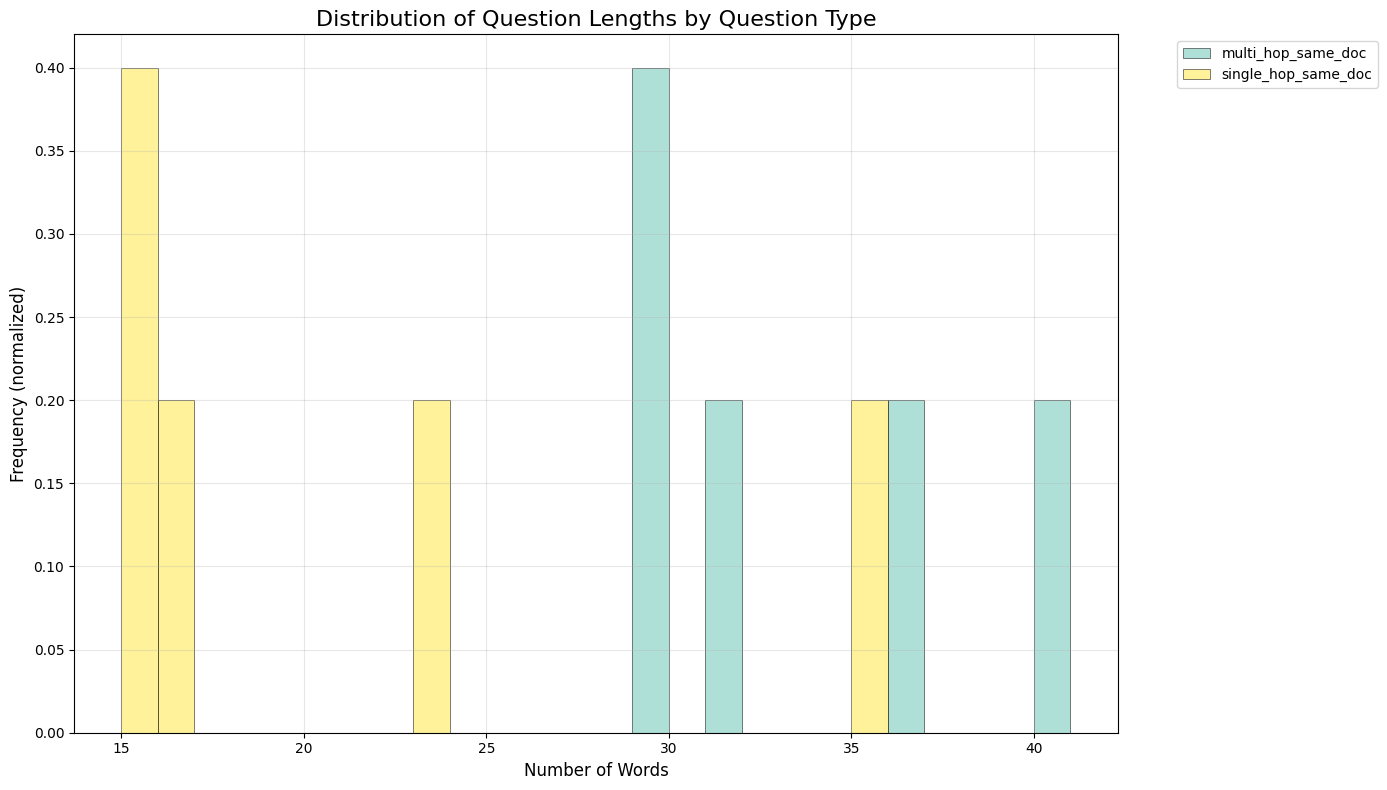

Question length statistics by type:

multi_hop_same_doc:
  Count: 5
  Min words: 29
  Max words: 40
  Mean words: 33.0

single_hop_same_doc:
  Count: 5
  Min words: 15
  Max words: 35
  Mean words: 20.8

Total questions: 10


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Group data by question type and count words
question_type_data = defaultdict(list)

for qa in qa_data:
    word_count = len(qa['question'].split())
    if 'tags' in qa and 'question_type' in qa['tags']:
        question_type = qa['tags']['question_type']
    else:
        question_type = 'Unknown'
    question_type_data[question_type].append(word_count)

# Get all unique question types and assign colors
question_types = list(question_type_data.keys())
colors = plt.cm.Set3(np.linspace(0, 1, len(question_types)))  # Using Set3 colormap for distinct colors

# Create the plot
plt.figure(figsize=(14, 8))

# Calculate bins range for all data
all_word_counts = [count for counts in question_type_data.values() for count in counts]
min_words = min(all_word_counts)
max_words = max(all_word_counts)
bins = range(min_words, max_words + 2)

# Plot histogram for each question type
for i, (question_type, word_counts) in enumerate(question_type_data.items()):
    plt.hist(word_counts, bins=bins, alpha=0.7, label=question_type, 
             color=colors[i], edgecolor='black', linewidth=0.5, density=True)

plt.title('Distribution of Question Lengths by Question Type', fontsize=16)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Frequency (normalized)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics for each question type
print("Question length statistics by type:")
print("=" * 50)
for question_type, word_counts in question_type_data.items():
    print(f"\n{question_type}:")
    print(f"  Count: {len(word_counts)}")
    print(f"  Min words: {min(word_counts)}")
    print(f"  Max words: {max(word_counts)}")
    print(f"  Mean words: {sum(word_counts)/len(word_counts):.1f}")

print(f"\nTotal questions: {len(all_word_counts)}")

In [9]:
from collections import Counter
import tiktoken

questions = [qa['question'] for qa in qa_data]  # Extract questions from the data

# Concatenate all questions into a single string
text = ' '.join(questions)

# Initialize the tiktoken tokenizer
tokenizer = tiktoken.get_encoding("o200k_base")

# Tokenize the text using tiktoken
token_ids = tokenizer.encode(text)

# Decode token IDs to token strings
tokens = [tokenizer.decode([token_id]) for token_id in token_ids]

# Count the frequency of each token in your data
frequency = Counter(tokens)

# Get the token ranks (lower token ID generally means higher frequency)
token_ranks = {token: rank for rank, token in enumerate(sorted(token_ids))}

# Normalize your frequencies using the inverse of the token rank
normalized_frequency = {}
for token, count in frequency.items():
    rank = token_ranks.get(token, tokenizer.n_vocab)
    inverse_rank = 1 / (rank + 1)  # Add 1 to avoid division by zero
    normalized_frequency[token] = count * inverse_rank

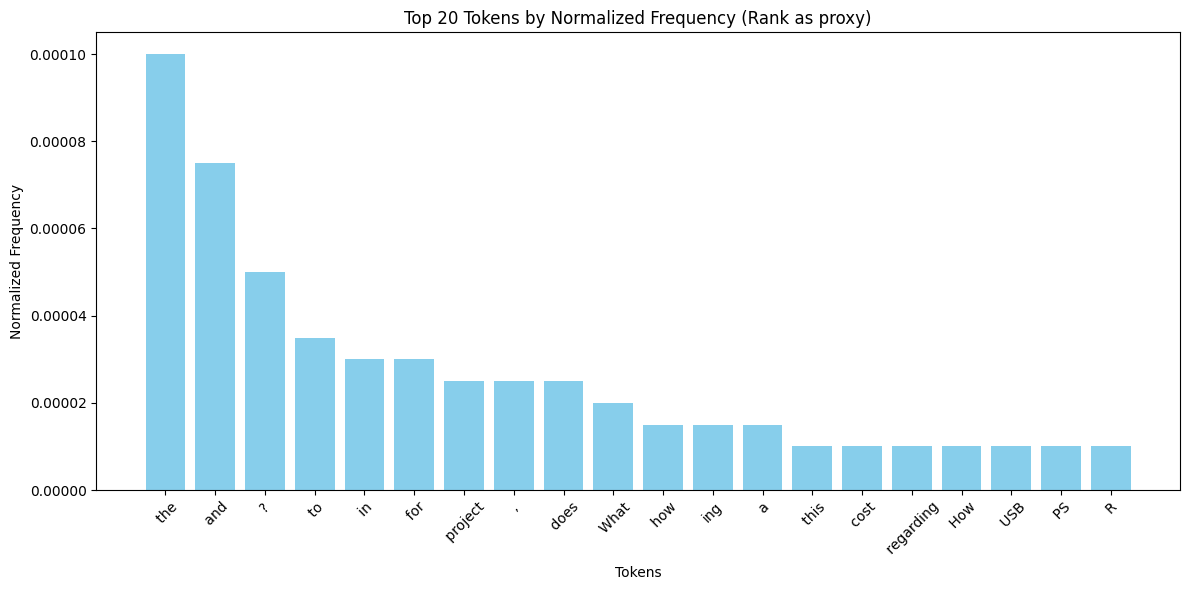

In [10]:
import matplotlib.pyplot as plt

# Select top 40 tokens based on normalized frequency
top_tokens = sorted(normalized_frequency.items(), key=lambda x: x[1], reverse=True)[:20]
tokens, frequencies = zip(*top_tokens)

# Plot the normalized frequencies
plt.figure(figsize=(12, 6))
plt.bar(tokens, frequencies, color='skyblue')
plt.xlabel('Tokens')
plt.ylabel('Normalized Frequency')
plt.title('Top 20 Tokens by Normalized Frequency (Rank as proxy)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

chat-example-embed-ada


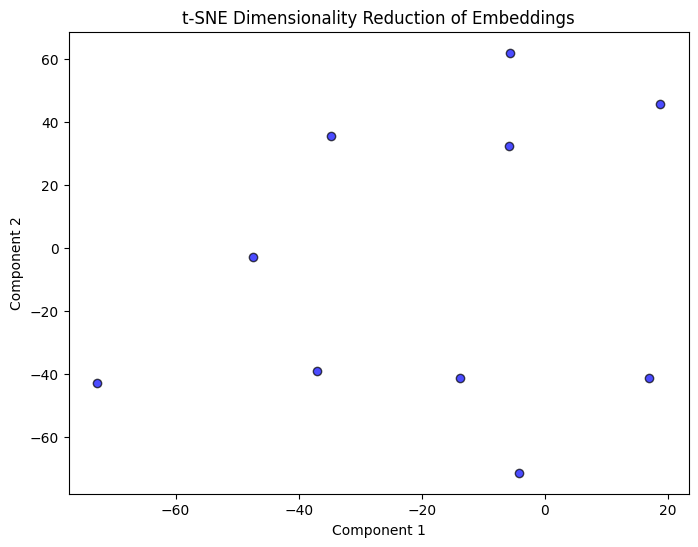

In [13]:
import os
from openai import AzureOpenAI
import dotenv
dotenv.load_dotenv()

# Set up Azure OpenAI API credentials
client = AzureOpenAI(
    api_version="2023-07-01-preview",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY")
)

questions = [qa['question'] for qa in qa_data]  # Extract questions from the data

print(os.getenv("AZURE_OPENAI_EMBEDDING_MODEL"))

response = client.embeddings.create(
    input=questions,
    model=os.getenv("AZURE_OPENAI_EMBEDDING_MODEL")  # Refer to the deployment name from .env file
)

embeddings = [item.embedding for item in response.data]

import numpy as np
from sklearn.manifold import TSNE

# Convert embeddings to a NumPy array
embeddings_array = np.array(embeddings)

# Initialize t-SNE with 2 components for visualization
tsne = TSNE(n_components=2, perplexity=5, random_state=42) # Tune the perplexity value to get good results
reduced_embeddings = tsne.fit_transform(embeddings_array)

import matplotlib.pyplot as plt

# Plot the reduced embeddings
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue', edgecolor='k', alpha=0.7)
plt.title('t-SNE Dimensionality Reduction of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()